#**Attention Is All You Need Notebook**
An implementation of the tranformer model from 2017 paper [Attention Is All You
Need](https://arxiv.org/pdf/1706.03762v5.pdf)


Transformers are a type of deep-learning model that has gained notoriety for often being the best model for language processing and computer vision tasks. This paper presents an implementation of the original transformer model from the 2017 paper Attention Is All You Need with an emphasis on creating easily digestible code and explanations. With readability being prioritized over efficiency, the corresponding Jupyter Notebook of my model provides a new perspective on how transformer model code can be written and contributes to the expanding transformer learning community. On the Multi30k English-German dataset the model received a BLEU score of 36.56 after being trained on Google Colab with Nvidia’s T4 GPU for under 2 hours--making my test results easy to reproduce for readers. A transformer model diagram is provided with more detail than any diagram readily obtainable on the web, and attention graphs are employed to show the final results of self-attention on different sentences.



### Licence

MIT License

Copyright (c) 2018 Ben Trevett  
Copyright (c) 2023 Mark Van Genderen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## Setup
written by Ben Trevett  
Find orginial at this [link](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb)

In [ ]:
!pip install torchtext==0.10
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 1.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.9.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.9.0 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but 

Import Libraries  
Note: If you receive any errors attempting to import libraries, please restart runtime and try again

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

loading dataset for vocabulary

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:03<00:00, 349kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 110kB/s] 


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 104kB/s] 


In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Set device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Set iterator

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Model 
written by Mark Van Genderen

### Model Configuration

In [ ]:
class ModelConfig:
    n_layers = 4
    input_dim = 5
    d_model = 256
    n_heads = 4
    output_dim = 1
    dropout = 0.1
    pf_dim = 2048
    

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            assert hasattr(self, k)
            self.__setattr__(k, v)

 ### Positional Encoding

Positional encoding does exactly as the name suggests, it encodes the position of the input words. This is necessary, since unlikely with many recurrence and convolution models, ours does not provide any other indication of the order of the embedded words. The paper recommends adding a fixed sin and cos function, but in this re-implementation, a learnable normal weighted matrix is used with the PyTorch function 'n.init.normal'. For either method the purpose remains the same, identical words in different positions should have different values, and word order should be recognized.

In [ ]:
class AbsolutePositionalEncoding(nn.Module):
    MAX_LEN = 256
    def __init__(self, d_model):
        super().__init__()
        self.W = nn.Parameter(torch.empty((self.MAX_LEN, d_model)))
        nn.init.normal_(self.W)

    def forward(self, x):
        """
        args:
            x: shape B x N x D
        returns:
            out: shape B x N x D
        """
        
        B = x.shape[0]
        N = x.shape[1]
        D = x.shape[2]
        out = torch.zeros(B,N,D)

        # add absolute positional encoding for each batch
        for b in range(B):
          out[b,:,:] = x[b,:,:] + self.W[0:N,0:D] # only use N * D weights
        
        return out

### Multi-Head Attention



As suggested by the title of this paper, multi-Head attention and self attention are most substantial innovation introduce in Attention Is All You Need. 
\begin{equation}
Attention(Q, K, V) = Dropout(Softmax \big(Mask(\frac{QK^T}{\sqrt{d_k}} \big)))V
\end{equation}
\begin{equation}
MultiHead(Q, K, V) = Concat(head_1,...,head_h)W^O
\end{equation}
\begin{equation}
head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)
\end{equation}
Q, K and V represent query, key and value respectively.  A major  advantage of this approach is that each head can be computed in parallel and attention can be paid to all past words, in lieu of the short term memory employed in recurrent language models.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads

        # create linear weight for key, query and value matrices
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)

        # linear output matrix
        self.fc_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, query, key, value, mask = None):
        """
        args:
            key: shape B x kl x d_model
            query: shape B x ql x d_model
            value: shape B x vl x d_model
        return:
            out: shape B x ql x d_model
        Requirements: kl = vl (often referred to as N_src in other modules)
        START BLOCK
        """
        ## Input Dimensions ##
        # B = batch size
        # d_model = hidden dimension
        # ql = query length
        # kl = key length
        # vl = value len
        #query = [B, ql, d_model]
        #key =   [B, kl, d_model]
        #value = [B, vl, d_model]
        B = query.shape[0]
        d_model = query.shape[2]
        ql = query.shape[1]
        kl = key.shape[1]
        vl = value.shape[1]
        

        # apply weights  
        #q = [B, ql, d_model]
        #k = [B, kl, d_model]
        #v = [B, vl, d_model]      
        q = self.fc_q(query)
        k = self.fc_k(key)
        v = self.fc_v(value)
        
      
        
        # separate the weighted query, key and value matrices into self.n_heads dimensions
        # we split the d_model(or hidden dimension) into self.n_heads parts

        # compute new dimensions
        #qh = [batch size, n_heads, query len, d_model//n_heads]
        #kh = [batch size, n_heads, key len, d_model//n_heads]
        #vh = [batch size, n_heads, value len, d_model//n_heads]
        # nd = new dimension = d_model//n_heads
        nd = d_model//self.n_heads 
        qh = torch.empty((B,self.n_heads,ql,nd)).to(device)
        kh = torch.empty((B,self.n_heads,kl,nd)).to(device)
        vh = torch.empty((B,self.n_heads,vl,nd)).to(device)

        # now lets convert these matrices into our new dimensions
        for h in range(self.n_heads):
          for n in range(nd):
            qh[:,h,:,n] = q[:,:,h*nd+n]
            kh[:,h,:,n] = k[:,:,h*nd+n]
            vh[:,h,:,n] = v[:,:,h*nd+n]

        # compute qh*(kh)^T
        # we only swap the last two dimesnion(key and d_model) which allows for 
        # matrix mult with qh
        numerator = torch.matmul(qh, torch.transpose(kh,-1,-2)) # B X n_heads X ql X kl

        # scale to prevent extremely small gradients (see 3.2.1 of paper)
        input = numerator/torch.sqrt(torch.FloatTensor([nd])).to(device) # B X n_heads X ql X kl    

        # apply mask
        if mask is not None:
          # B X n_heads X ql X kl
          input = input.masked_fill(mask == 0, -1e10) # if true, set to value near -infinity

        # apply softmax along 
        attention = torch.softmax(input, dim = -1) # B X n_heads X ql X kl

        # apply dopout and multiply by vh
        y = torch.matmul(self.dropout(attention), vh) # B X n_heads X ql X nd

        out = torch.empty(B,ql,d_model).to(device) 
        # re-combine head (our form of concatenation as described in above eqn
        for h in range(self.n_heads):
          for n in range(nd):
            out[:,:,h*nd+n] = y[:,h,:,n]

        out = self.fc_o(out)  # B x ql x d_model
  
        
        return out, attention

### Feed Forwards


\begin{equation}
FFN(x) = max(0, Dropout(xW_1 + b_1))W_2 + b_2
\end{equation}

The feed forward layer can be described by the equation above and adds learnable parameters to our model.

In [ ]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, pf_dim, dropout):
    super().__init__()
    self.lt_1 = nn.Linear(d_model, pf_dim)
    self.lt_2 = nn.Linear(pf_dim, d_model)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x):
    # compute standard Feed Forward
    x = self.dropout(torch.relu(self.lt_1(x)))
    x = self.lt_2(x)
    return x

### Encoder



At a high level, the encoder's function is to make the input sequence to the decoder with some learnable parameters.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, cfg: ModelConfig): 
        super().__init__()
        self.d_model = cfg.d_model
        self.n_heads = cfg.n_heads
        self.attention = MultiHeadAttention(d_model=cfg.d_model, 
                                            n_heads=cfg.n_heads, 
                                            dropout=cfg.dropout)
        self.pff = PositionwiseFeedForward(d_model=cfg.d_model, 
                                           pf_dim=cfg.pf_dim, 
                                           dropout=cfg.dropout)
        self.relu = nn.ReLU()
        self.ln1 = nn.LayerNorm(cfg.d_model)
        self.ln2 = nn.LayerNorm(cfg.d_model)
        self.dropout = nn.Dropout(cfg.dropout) 
    
    def forward(self, x, src_mask):
        """
        args:
            x: shape B x N x D
            src_mask: shape B x 1 x 1 x N
        returns:
            out: shape B x N x D
        """
        
        # using postnorm as desibed in paper
        at, _ = self.attention(x,x,x,src_mask)
        a1 = x + self.dropout(at.to(device))
        l1 = self.ln1(a1)

        ffn = self.pff(l1).to(device) 
        a2 = l1 + self.dropout(ffn)
        out = self.ln2(a2)
        

        return out

In [ ]:
class Encoder(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()

        self.cfg = cfg
        self.token_embed = nn.Embedding(cfg.input_dim, cfg.d_model)
        self.ape = AbsolutePositionalEncoding(d_model=cfg.d_model)
        self.EncoderLayer = nn.ModuleList([
            EncoderLayer(cfg=cfg) for _ in range(cfg.n_layers)
        ])
        self.dropout = nn.Dropout(self.cfg.dropout) 
    
    def forward(self, x, src_mask): 
        """
        args:
            x: shape B x N
            src_mask: shape B x 1 x 1 x N
        returns:
            out: shape B x N x D
        """
    
        # encode
        t_emb = self.token_embed(x)*(torch.sqrt(torch.DoubleTensor([self.cfg.d_model])).to(device))
        emb = self.ape(t_emb) # absolute postion embed 
        emb = emb.type(torch.FloatTensor)  #must use float since dropout doesn't work with long            
        enc = self.dropout(emb.to(device)) # ensure tensors are on same device
        for n in range(self.cfg.n_layers):
          enc = self.EncoderLayer[n](enc, src_mask)
        out = enc
       
        return out

### Decoder

At a high level, the decoder's function is to receive encoded input sequence, compare it to the target sequence, and output the likelihoods of any next word.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, cfg): 
        super().__init__()
        self.d_model = cfg.d_model
        self.n_heads = cfg.n_heads
        self.attention = MultiHeadAttention(d_model=cfg.d_model, 
                                            n_heads=cfg.n_heads, 
                                            dropout=cfg.dropout)
        self.ecoder_attention = MultiHeadAttention(d_model=cfg.d_model, 
                                            n_heads=cfg.n_heads, 
                                            dropout=cfg.dropout)
        self.pff = PositionwiseFeedForward(d_model=cfg.d_model, 
                                           pf_dim=cfg.pf_dim, 
                                           dropout=cfg.dropout)
        self.relu = nn.ReLU()
        self.ln1 = nn.LayerNorm(cfg.d_model)
        self.ln2 = nn.LayerNorm(cfg.d_model)
        self.ln3 = nn.LayerNorm(cfg.d_model)
        self.dropout = nn.Dropout(cfg.dropout) 

    
    def forward(self, x, enc_out, trg_mask, src_mask):
        """
        args:
            x: shape B x N x D
            enc_out: B x 1 x 1 x N_src
            trg_mask: B x 1 x N_trg x N_trg
            src_mask: B x 1 x 1 x N_src
        returns:
            out: shape B x N_trg x D
        """
        
        # using postnorm as described in paper
        at1, _ = self.attention(x,x,x,trg_mask)
        a1 = x + self.dropout(at1.to(device))
        l1 = self.ln1(a1)

        at2, attention = self.ecoder_attention(l1,enc_out,enc_out,src_mask)
        a2 = l1 + self.dropout(at2)
        l2 = self.ln2(a2)

        ffn = self.pff(l2).to(device) 
        a3 = l2 + self.dropout(ffn)
        out = self.ln3(a3)
        

        return out, attention

In [ ]:
class Decoder(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()

        self.cfg = cfg
        self.token_embed = nn.Embedding(cfg.input_dim, cfg.d_model)
        self.ape = AbsolutePositionalEncoding(d_model=cfg.d_model)
        self.DecoderLayer = nn.ModuleList([
            DecoderLayer(cfg=cfg) for _ in range(cfg.n_layers)
        ])
        self.dropout = nn.Dropout(self.cfg.dropout)
        self.ln_out = nn.Linear(cfg.d_model, cfg.output_dim)
        
    
    def forward(self, x, enc_out, trg_mask, src_mask):
        """
        args:
            x: shape B x N_trg
            enc_out: B x N_src X D
            trg_mask: B x 1 x N_trg x N_trg
            src_mask: B x 1 x 1 x N_src
        returns:
            out: shape B x N x D
        """
    
        # encode
        t_emb = self.token_embed(x)*(torch.sqrt(torch.DoubleTensor([self.cfg.d_model])).to(device))
        emb = self.ape(t_emb) # absolute postion embed     
        emb = emb.type(torch.FloatTensor)  #must use float since dropout doesn't work with long        
        dec = self.dropout(emb.to(device)) # ensure tensors are on same device
        for n in range(self.cfg.n_layers):
          dec, attention = self.DecoderLayer[n](dec, enc_out, trg_mask, src_mask) # grabbing attention of last layer
        
        
        out = self.ln_out(dec)
       
        return out, attention

### Transformer

The transformer in its entirety is composed of the encoder, decoder, and some loss function to make sense of the probabilities and train our model.

In [ ]:
class TransformerModel(nn.Module):
  def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

  # make standard source mask       
  def make_src_mask(self, src):
    """
    args:
        src: shape B x N_src
    returns:
        out: B x 1 x 1 x N_src
    """
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    return src_mask     


  # make standard target mask
  def make_trg_mask(self, trg): 
    """
    args:
        trg: shape B x N_trg
    returns:
        out: B x 1 x N_trg x N_trg
    """
    N_trg = trg.shape[1]
    pad = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2) # B x 1 x 1 x D_trg
    # bottom triangle
    bt = torch.tril(torch.ones((N_trg, N_trg))).to(self.device) # D_trg x D_trg
    trg_mask = pad * bt #  B x 1 x N_trg x N_trg
    
    return trg_mask

  def forward(self, src, trg):

    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)


    enc_out = self.encoder(src, src_mask)
    output, attention = self.decoder(trg, enc_out, trg_mask, src_mask)
    return output, attention



## Training
written by Ben Trevett  
Find orginial at this [link](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb)

In [ ]:
# parameters
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
D_MODEL = 256
LAYERS = 3
HEADS = 8
PF_DIM = 512
DROPOUT = 0.1

# config
cfg = ModelConfig(n_layers=LAYERS, input_dim=INPUT_DIM, d_model=D_MODEL, 
                  n_heads=HEADS, output_dim=OUTPUT_DIM, dropout=DROPOUT,
                  pf_dim = PF_DIM)

enc = Encoder(cfg)
dec = Decoder(cfg)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = TransformerModel(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,619,973 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0

    print(len(iterator))
    for i, batch in enumerate(iterator):
        print(i)
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

227
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
Epoch: 01 | Time: 9m 37s
	Train Loss: 4.583 | Train PPL:  97.835
	 Val. Loss: 3.451 |  Val. PPL:  31.526
227
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [ ]:
### trg_msk demonstration
#do this when your at this point of desbitin the model

Examples:

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'past', 'a', 'gate', '.', '<eos>']


<ipython-input-107-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-107-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


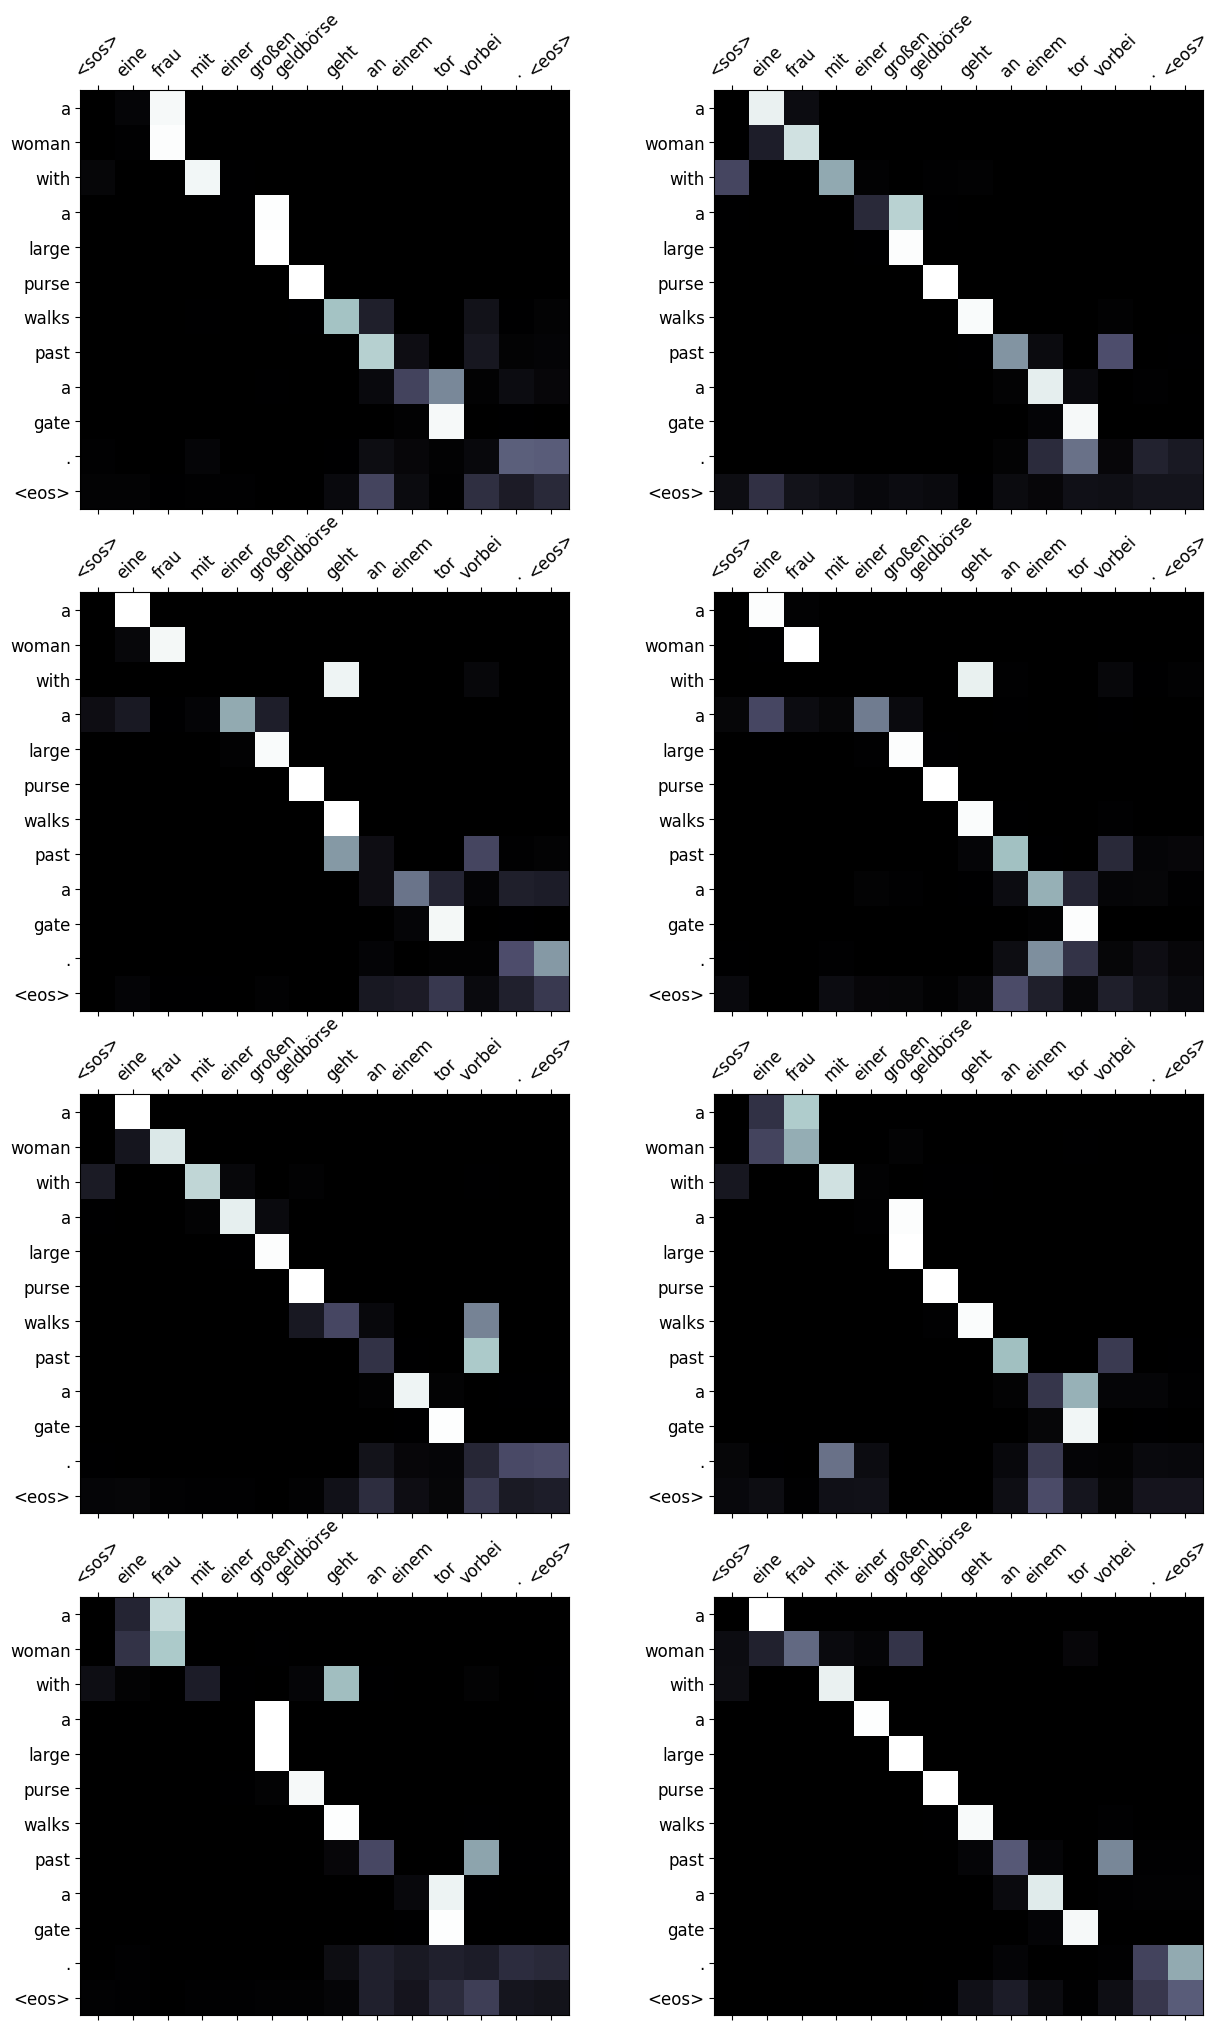

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


<ipython-input-107-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-107-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


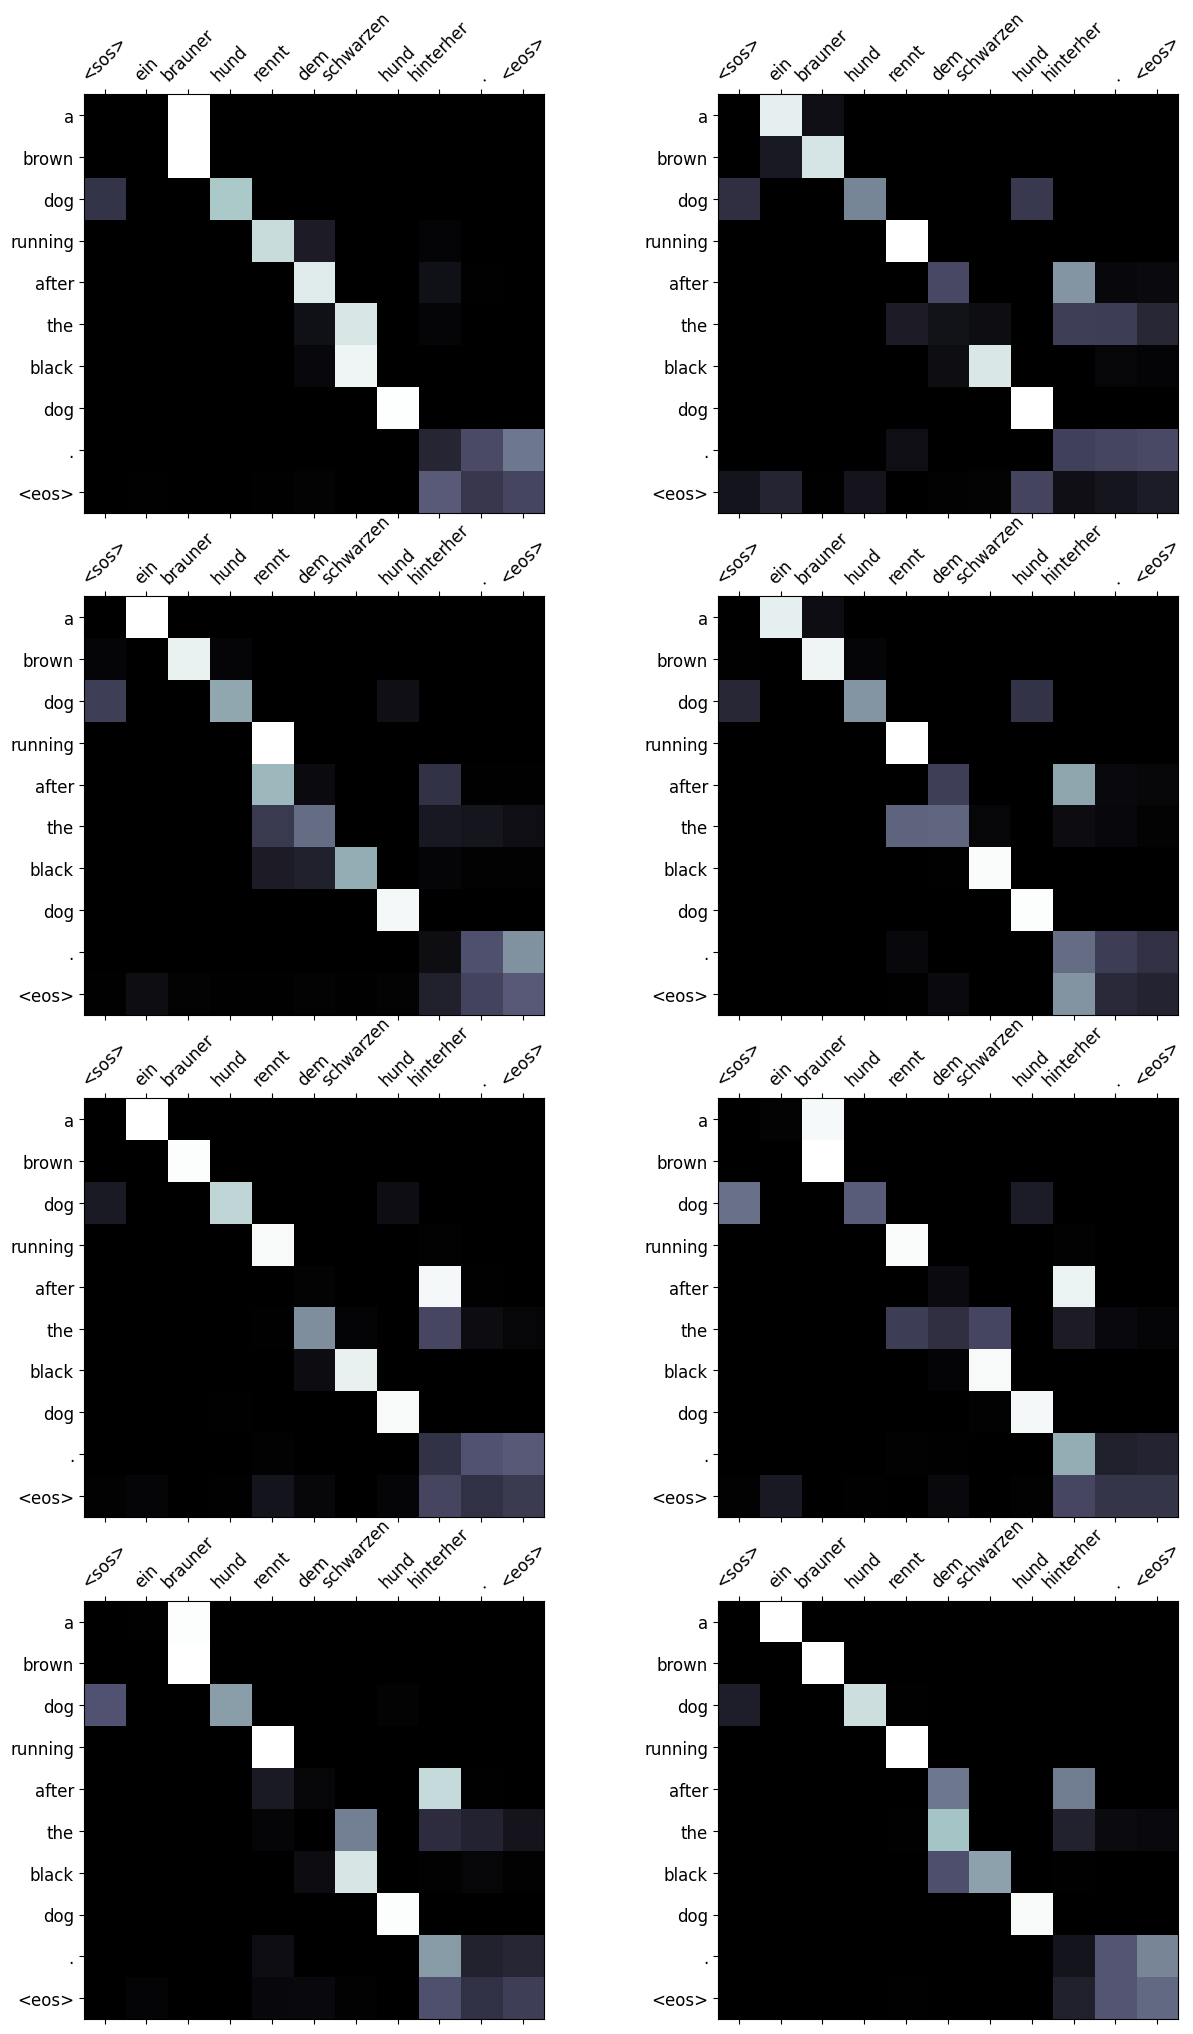

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


<ipython-input-107-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-107-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


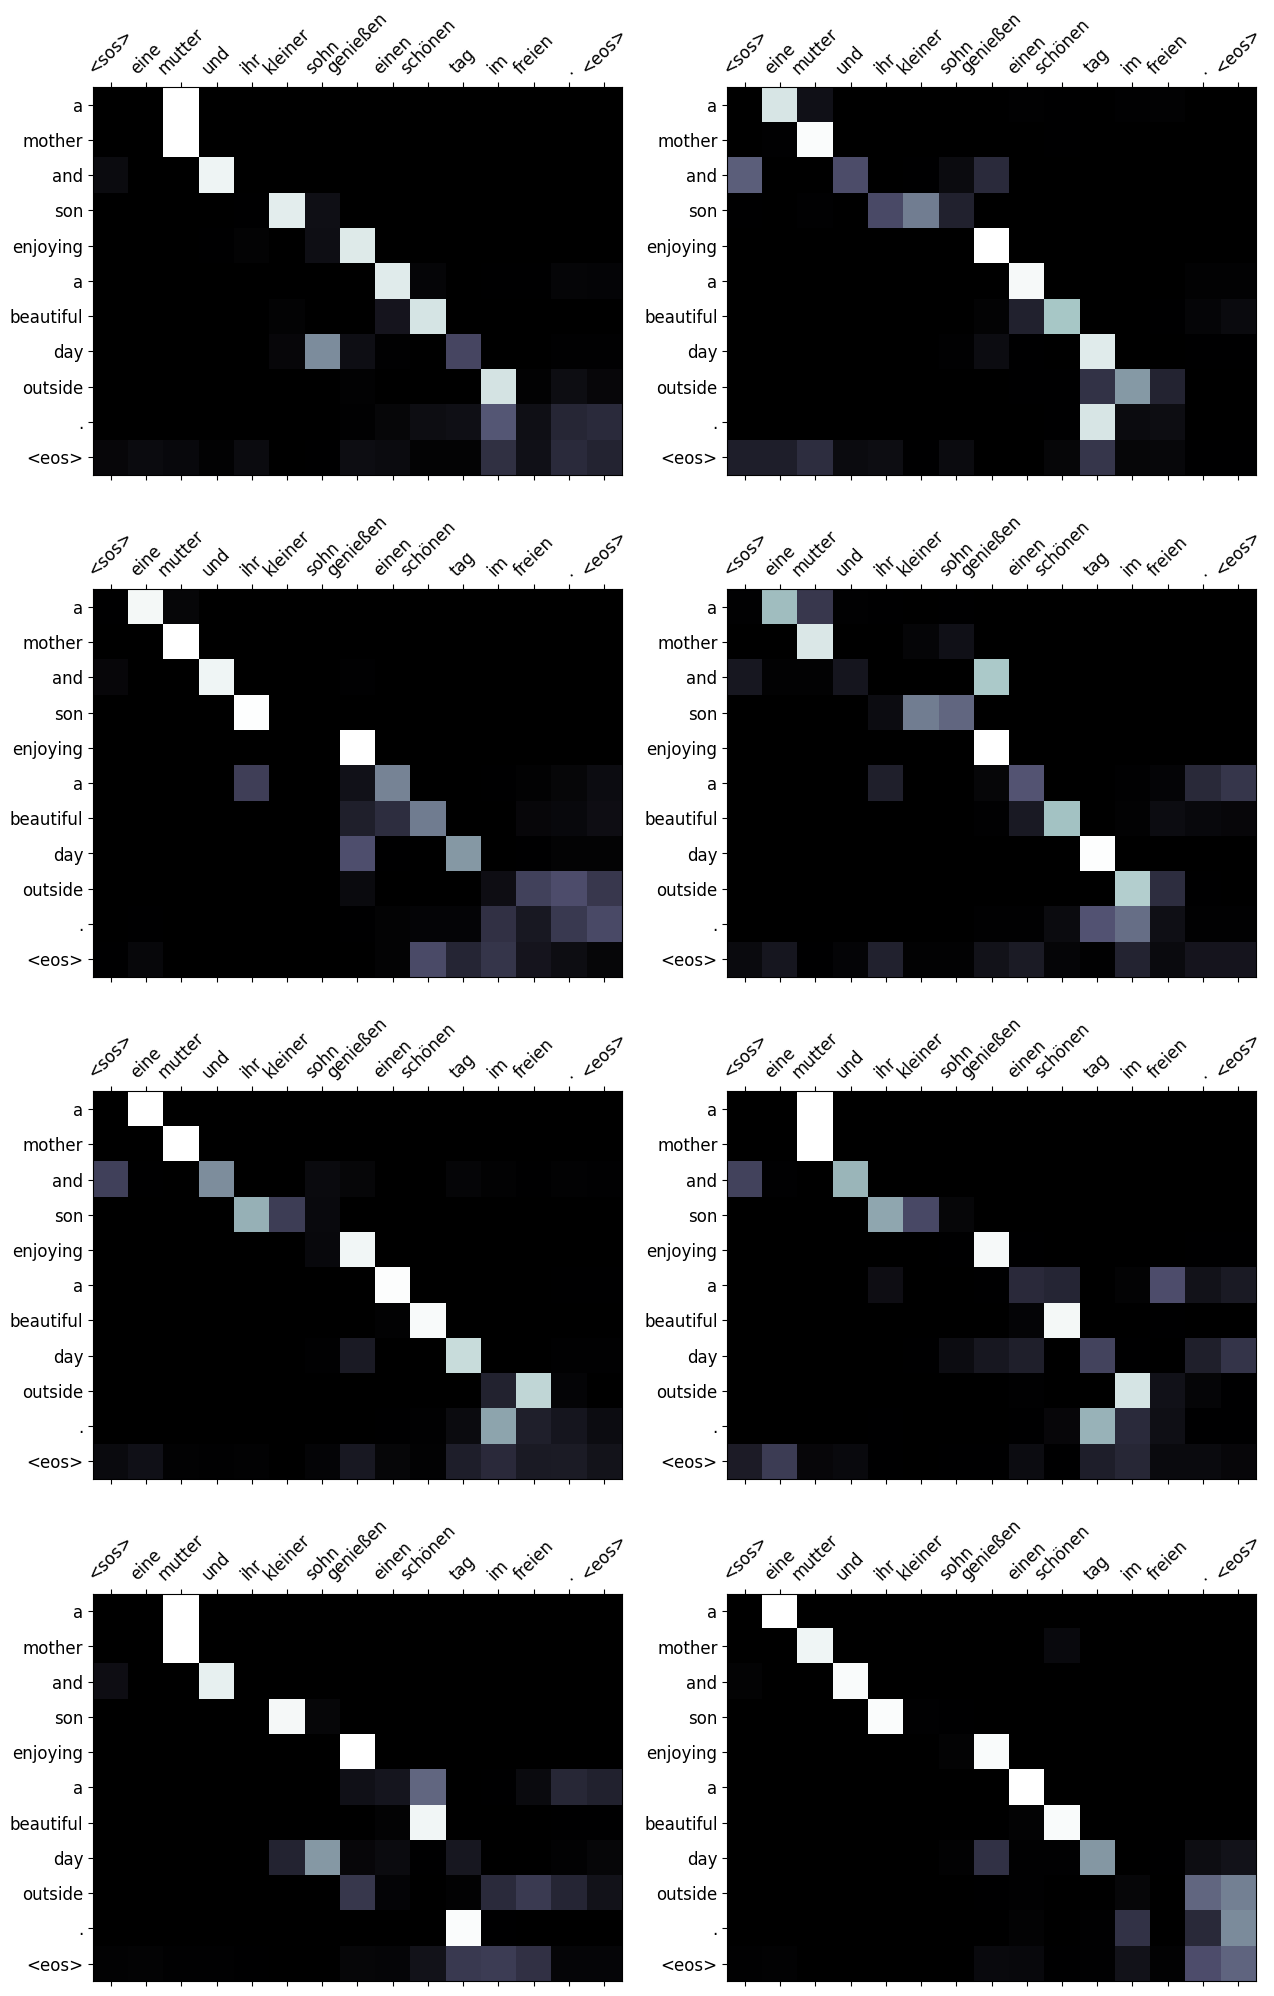

In [ ]:
display_attention(src, translation, attention)

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 36.56


## Demonstrations
written by Mark Van Genderen

### Source Mask Demonstration
Small code snipped to demonstrate the use of masked_fill will an exmples in and source mask

In [ ]:
### src_mask demonstation
mask = torch.tensor([[[[ True,  True,  True, True, False]]],
                     [[[ True, False, True,  True,  True]]]])
print("mask", mask.shape, mask)
# src.shape = [batch_size, src_len]
# src_mask.shape = [batch_size, 1, 1, src_len]

# key and value lenght always equal
# src_len alway = key_len? yes
# energy.shape = [batch_size, num_heads, query_len, key_len]
#        set to  [2, 3, 3, 5]

input = torch.ones((2, 3, 3, 5))
out = input.masked_fill(mask == 0, float("-inf"))
print("out", out.shape, out) 

mask torch.Size([2, 1, 1, 5]) tensor([[[[ True,  True,  True,  True, False]]],


        [[[ True, False,  True,  True,  True]]]])
out torch.Size([2, 3, 3, 5]) tensor([[[[1., 1., 1., 1., -inf],
          [1., 1., 1., 1., -inf],
          [1., 1., 1., 1., -inf]],

         [[1., 1., 1., 1., -inf],
          [1., 1., 1., 1., -inf],
          [1., 1., 1., 1., -inf]],

         [[1., 1., 1., 1., -inf],
          [1., 1., 1., 1., -inf],
          [1., 1., 1., 1., -inf]]],


        [[[1., -inf, 1., 1., 1.],
          [1., -inf, 1., 1., 1.],
          [1., -inf, 1., 1., 1.]],

         [[1., -inf, 1., 1., 1.],
          [1., -inf, 1., 1., 1.],
          [1., -inf, 1., 1., 1.]],

         [[1., -inf, 1., 1., 1.],
          [1., -inf, 1., 1., 1.],
          [1., -inf, 1., 1., 1.]]]])
